# Adaptive Learning with NV Centers - Data Analysis

## Import Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import qinfer as qi
import models as m
from adaptive import *
from nvdata import *
import scipy.stats as st
import scipy.io as sio

### Import Data

In [2]:
rabi_data = sio.loadmat('../data/rabi.mat')['avgData'] * 200 * 50000
rabi_p = (rabi_data[2,:] - rabi_data[1,:]) / (rabi_data[0,:] - rabi_data[1,:])
rabi_p_stds = est_std(rabi_p, rabi_data[0,:], rabi_data[1,:])
rabi_x = np.linspace(0,0.5,rabi_p.size)

ramsey_data = sio.loadmat('../data/ramsey.mat')['avgData'] * 200 * 50000
ramsey_p = (ramsey_data[2,:] - ramsey_data[1,:]) / (ramsey_data[0,:] - ramsey_data[1,:])
ramsey_p_stds = est_std(rabi_p, ramsey_data[0,:], ramsey_data[1,:])
ramsey_x = np.linspace(0, 2, ramsey_p.size)

In [ ]:
a = HeuristicData('../data/full_bayes_risk.pkl')

In [3]:
transfer_function = HeuristicData('../data/transfer_function_new.pkl')
bernoulli_risk = HeuristicData('../data/bernoulli_risk_final.pkl')
full_risk = HeuristicData('../data/full_bayes_risk.pkl')
linear = HeuristicData('../data/alternating_linear_final.pkl')
linear_full = HeuristicData('../data/alternating_linear_final_full.pkl')
classic_linear = HeuristicData('../data/classic_linear_final.pkl')
power_curve = HeuristicData('../data/power_curve.pkl')

Imported existing Panel with 7 DataFrames from ../data/transfer_function_new.pkl
Imported existing Panel with 100 DataFrames from ../data/bernoulli_risk_final.pkl
Imported existing Panel with 65 DataFrames from ../data/full_bayes_risk.pkl
Imported existing Panel with 139 DataFrames from ../data/alternating_linear_final.pkl
Imported existing Panel with 187 DataFrames from ../data/alternating_linear_final_full.pkl
Imported existing Panel with 100 DataFrames from ../data/classic_linear_final.pkl
Imported existing Panel with 15 DataFrames from ../data/power_curve.pkl


In [ ]:
HeuristicData('../data/full_bayes_risk_reanalyzed.pkl')

for idx_df in range(full_risk.n_dataframes):
    df = full_risk.panel[idx_df]

In [4]:
panels = {
  #  'Predetermined Linear': linear,
    'Predetermined Linear Full': linear_full,
    #'Classic Linear': classic_linear,
    'Bernoulli Risk': bernoulli_risk,
    'Full Risk': full_risk
}

<IPython.core.display.Javascript object>


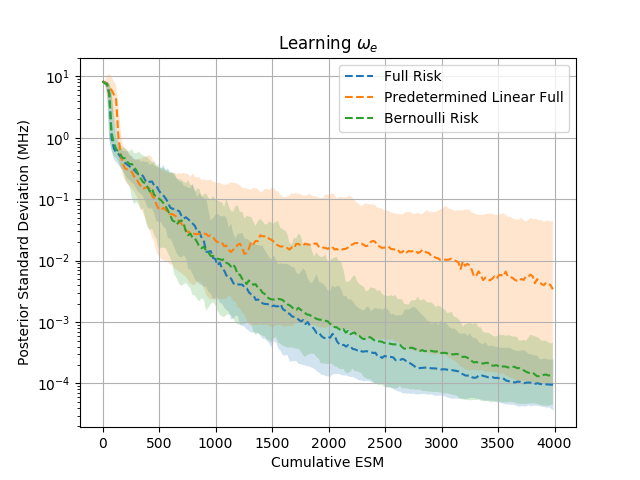

Full Risk
Predetermined Linear Full
Bernoulli Risk


In [5]:
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
x_column='cum_eff_num_bits'

fig = plt.figure()

for name, panel in panels.iteritems():
    print name
    x_vals, y_vals = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,idx_param], x_column=x_column)
    #x_vals, An_cov = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,3], x_column=x_column)
    lower, upper, mid = np.percentile(y_vals, [90,10,50], axis=0)
    plt.fill_between(x_vals, lower, upper, alpha=0.2)
    #plt.semilogy(x_vals, np.mean(y_vals, axis=0), label=name)
    plt.semilogy(x_vals, mid, '--', label=name)

plt.grid()
plt.ylabel(r'Posterior Standard Deviation (MHz)')
plt.xlabel('Cumulative ESM')
plt.title('Learning ${}$'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.legend()

In [120]:
cov = np.array(list(classic_linear.panel[34].smc_cov))
inv_std_mat, diag_idxs = np.zeros(cov.shape), (np.s_[:],) + np.diag_indices(cov.shape[-1])
inv_std_mat[diag_idxs] = 1/ np.sqrt(cov[diag_idxs])
corr = np.matmul(inv_std_mat, np.matmul(cov, inv_std_mat))

<IPython.core.display.Javascript object>


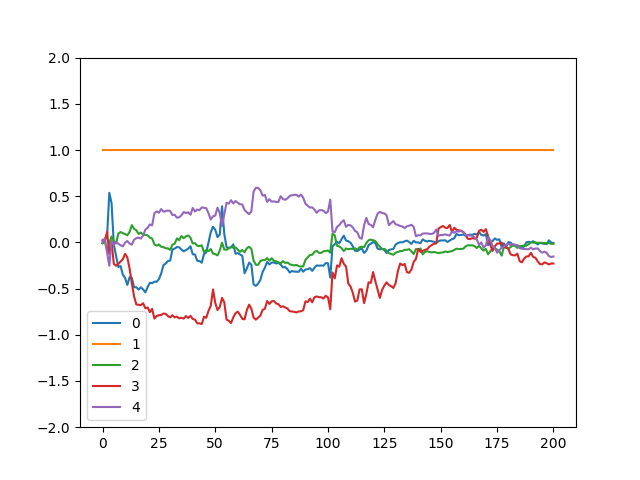

In [121]:
plt.figure()
idx1 = 1
for idx2 in range(5):
    plt.plot(corr[:,idx1,idx2], label='{}'.format(idx2))
plt.ylim([-2,2])
plt.legend()

In [ ]:
full_ri

In [4]:
def redo_eff_num_bits(hd):
    new_hd = HeuristicData('../data/tmp.pkl')
    for idx in range(hd.n_dataframes):
        df = hd.panel[idx]
        alpha, beta = list(df.smc_mean)
        n_meas = np.array(list(hd.panel[idx].expparam)[1:])['n_meas'].flatten()
        n_meas = np.concatenate([[0], n_meas])
        new_esm = esm * n_meas
        hd._df_dict[idx].update(
            DataFrame({'eff_num_bits':new_esm,'cum_eff_num_bits':np.cumsum(new_esm)})
        )
        new_hd.append(hd.panel[idx])
    return new_hd

### Power Curve

<IPython.core.display.Javascript object>


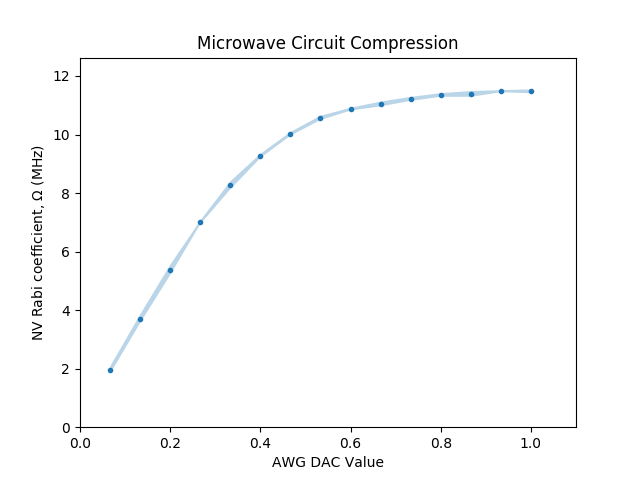

In [25]:
linear_powers = np.empty(power_curve.n_dataframes)
power_curve_ests = np.empty((power_curve.n_dataframes, 5))
power_curve_stds = np.empty((power_curve.n_dataframes, 5))
for idx_df in range(power_curve.n_dataframes):
    df = power_curve.panel[idx_df]
    linear_powers[idx_df] = 10 ** (np.array(list(df.heuristic_value))[-1] / 20)
    power_curve_ests[idx_df, :] = np.array(list(df.smc_mean))[-1,:5]
    power_curve_stds[idx_df, :] = np.sqrt(np.diag(np.array(list(df.smc_cov))[-1,:5,:5]))

plt.figure()
idx_param = 0
plt.plot(linear_powers, power_curve_ests[:,idx_param],'.')
plt.fill_between(
    linear_powers, 
    power_curve_ests[:,idx_param] - 3*power_curve_stds[:,idx_param], 
    power_curve_ests[:,idx_param] + 3*power_curve_stds[:,idx_param],
    alpha=0.3
)
plt.ylim([0, 1.1*np.amax(power_curve_ests[:,idx_param])])
plt.xlim([0, 1.1*np.amax(linear_powers)])

plt.title('Microwave Circuit Compression')
plt.xlabel('AWG DAC Value')
plt.ylabel('NV Rabi coefficient, $\Omega$ (MHz)')

In [161]:
offsets = []
for idx_df in range(transfer_function.n_dataframes):
    df = transfer_function.panel[idx_df]
    offsets.append(df.expparam[1]['wo'])
offsets = np.array(offsets).flatten()
n_offsets = offsets.size

transfer_function_ests = np.empty((n_offsets, 5))
transfer_function_stds = np.empty((n_offsets, 5))
for idx_df in range(transfer_function.n_dataframes):
    df = transfer_function.panel[idx_df]
    transfer_function_ests[idx_df, :] = df.smc_mean[200][:5]
    transfer_function_stds[idx_df, :] = np.sqrt(np.diag(df.smc_cov[200][:5,:5]))

In [86]:
tf_data = np.array([
    [
        list(new_linear.panel[idx_df][label][1:] )
        for idx_df in range(new_linear.n_dataframes)
    ] for label in ['bright', 'dark', 'signal']
]).transpose(1,2,0)

<IPython.core.display.Javascript object>


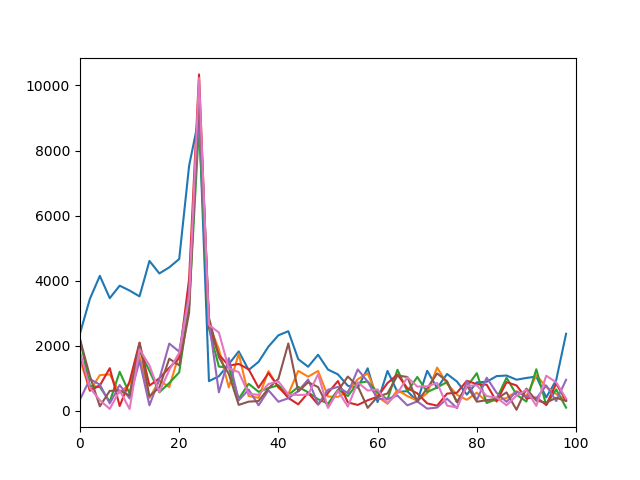

(0, 100)

In [83]:
fig = plt.figure()
for idx in range(7):
    plt.plot(
        np.fft.fftshift(np.fft.fftfreq(tf_data.shape[1]//2, 0.5/100)),
        np.abs(np.fft.fftshift(np.fft.fft(tf_data[idx,::2,2]-np.mean(tf_data[idx,:,2]))))
    )
plt.xlim([0,100])

<IPython.core.display.Javascript object>


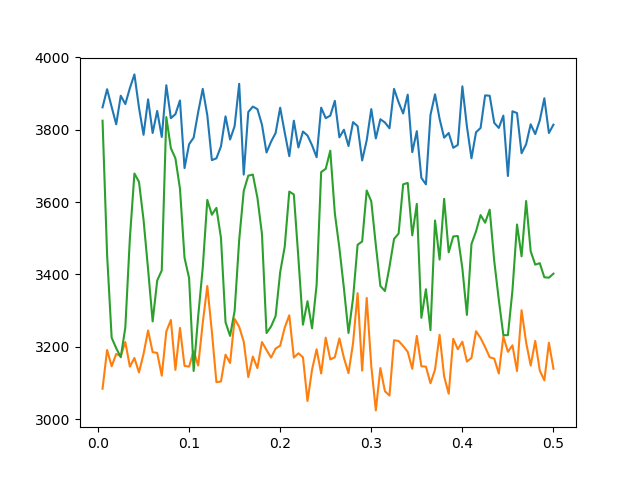

In [162]:
fig = plt.figure()
plt.plot(rabi_x[1:], tf_data[0,::2,0])
plt.plot(rabi_x[1:], tf_data[0,::2,1])
plt.plot(rabi_x[1:], tf_data[0,::2,2])

<IPython.core.display.Javascript object>


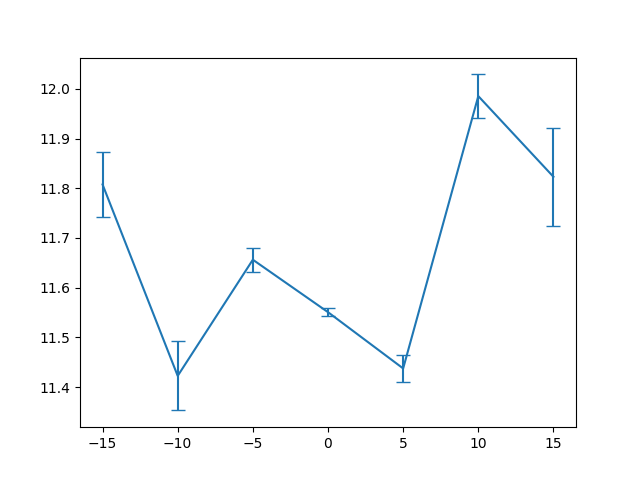

<Container object of 3 artists>

In [163]:
plt.figure()
plt.errorbar(offsets, transfer_function_ests[:,0], yerr=transfer_function_stds[:,0], capsize=5)

<IPython.core.display.Javascript object>


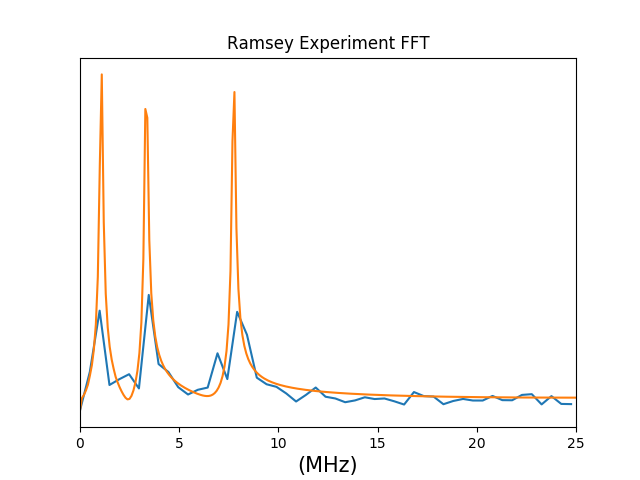

In [101]:
df = linear.panel[10]

fig = plt.figure()

freqs = np.fft.fftshift(np.fft.fftfreq(ramsey_x.size, ramsey_x[1]-ramsey_x[0]))
ramsey_fft = np.fft.fftshift(np.fft.fft(ramsey_p-np.mean(ramsey_p)))
plt.plot(freqs, np.abs(ramsey_fft))

modelparams = list(df.smc_mean)[-1][:5]
freqs, sim_fft = simulate_ramsey_fft(modelparams, max_tau=10,n=501,tp=0.022)
plt.plot(freqs, np.abs(sim_fft))

plt.xlim([0,25])
plt.xlabel(r'(MHz)', size=15)
plt.yticks([])
plt.title('Ramsey Experiment FFT')

In [66]:
new_linear = HeuristicData('../data/alternating_linear_final.pkl')
linear = HeuristicData('../data/alternating_linear_final.pkl.bak')

Created empty Panel.
Imported existing Panel with 43 DataFrames from ../data/alternating_linear_final.pkl.bak


In [68]:
new_linear.save()

In [1]:
linear._df_dict[0].update(
    DataFrame({'eff_num_bits':new_esm,'cum_eff_num_bits':np.cumsum(new_esm)})
)

NameError: name 'linear' is not defined

<IPython.core.display.Javascript object>


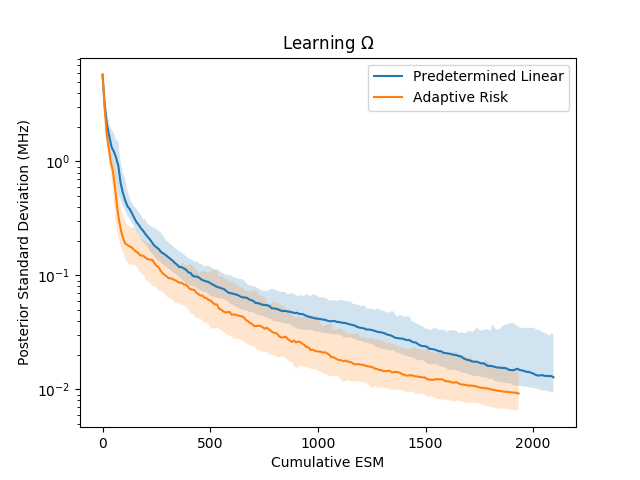

Predetermined Linear
Adaptive Risk


In [185]:
idx_param = m.RabiRamseyModel.IDX_OMEGA
x_column='cum_eff_num_bits'

fig = plt.figure()

for name, panel in panels.iteritems():
    print name
    x_vals, y_vals = extract_panel_data(panel, 'smc_cov', idxs=np.s_[idx_param,idx_param], x_column=x_column)
    lower, upper, mid = np.percentile(y_vals, [90,10,50], axis=0)
    plt.fill_between(x_vals, np.sqrt(lower), np.sqrt(upper), alpha=0.2)
    plt.semilogy(x_vals, np.sqrt(mid), label=name)


plt.ylabel(r'Posterior Standard Deviation (MHz)')
plt.xlabel('Cumulative ESM')
plt.title('Learning ${}$'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.legend()

<IPython.core.display.Javascript object>


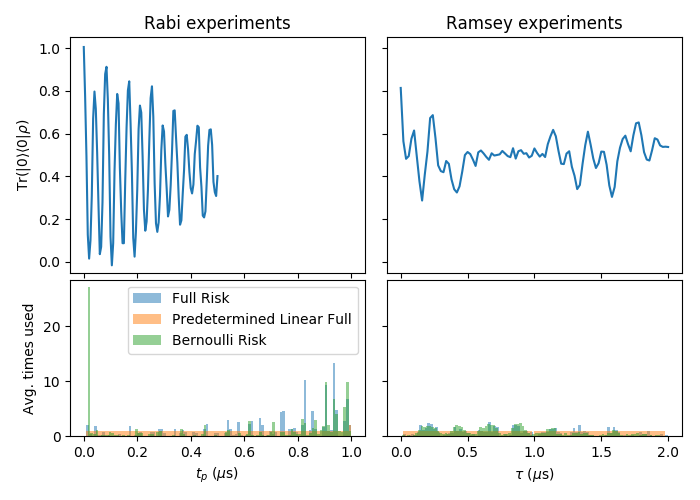

In [139]:
fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(2,2,height_ratios=[1.5,1])

ax_rabi_hist = plt.subplot(gs[1,0])
for name, panel in panels.iteritems():
    _, eps_array = extract_panel_data(panel,'expparam',skip_first=True,idxs=np.s_[0])
    ts = eps_array['t'][eps_array['emode']==m.RabiRamseyModel.RABI]
    plt.hist(ts, bins=100, alpha=0.5, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes)
plt.xlabel(r'$t_p$ ($\mu$s)')
plt.ylabel(r'Avg. times used')
plt.legend()

ax_rabi = plt.subplot(gs[0,0], sharex=ax_rabi_hist)
plt.plot(rabi_x, rabi_p)
plt.title('Rabi experiments')
plt.ylabel(r'Tr$(|0\rangle\langle 0|\rho)$')
plt.ylim([-0.05,1.05])


ax_ramsey_hist = plt.subplot(gs[1,1], sharey=ax_rabi_hist)
for name, panel in panels.iteritems():
    _, eps_array = extract_panel_data(panel,'expparam',skip_first=True,idxs=np.s_[0])
    ts = eps_array['tau'][eps_array['emode']==m.RabiRamseyModel.RAMSEY]
    plt.hist(ts, bins=100, alpha=0.5, label=name, normed=False, weights=np.ones(ts.size)/panel.n_dataframes)
plt.xlabel(r'$\tau$ ($\mu$s)')

ax_ramsey = plt.subplot(gs[0,1], sharex=ax_ramsey_hist, sharey=ax_rabi)
plt.plot(ramsey_x, ramsey_p)
plt.title('Ramsey experiments')
plt.ylim([-0.05,1.05])


plt.setp(ax_ramsey.get_xticklabels(), visible=False)
plt.setp(ax_ramsey.get_yticklabels(), visible=False)
plt.setp(ax_rabi.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_hist.get_yticklabels(), visible=False)

gs.tight_layout(fig,h_pad=0)

<IPython.core.display.Javascript object>


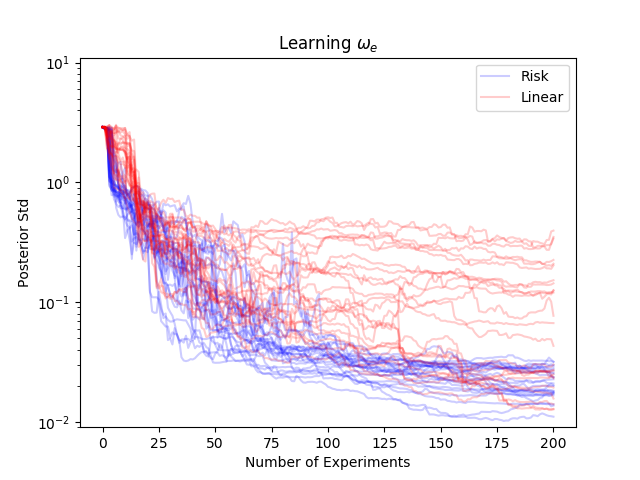

In [37]:
fig =plt.figure()
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
ham_model = m.RabiRamseyModel()

for idx_df in range(bernoulli_risk.n_dataframes):
    df = bernoulli_risk.panel[idx_df]
    label = 'Risk' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]), color='b',label=label,alpha=0.2)
    
for idx_df in range(linear.n_dataframes):
    df = linear.panel[idx_df]
    label = 'Linear' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]),'r',label=label, alpha=0.2)
    
plt.xlabel('Number of Experiments')
plt.ylabel('Posterior Std')
plt.ylim([0.9*10**-2,1.1*10])
plt.title('Learning ${}$'.format(ham_model.modelparam_names[idx_param]))
plt.legend()

Imported existing Panel with 24 DataFrames from ../data/bernoulli_risk.pkl


<IPython.core.display.Javascript object>


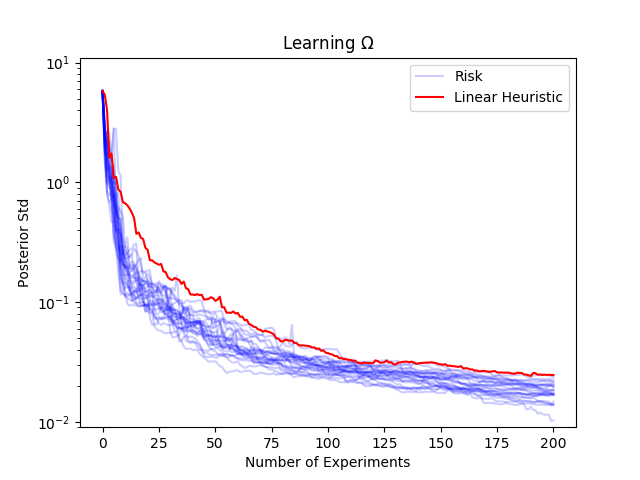

Imported existing Panel with 2 DataFrames from ../data/linear_heuristic_9.pkl


In [4]:
panel_bernoulli_risk = HeuristicData('../data/bernoulli_risk.pkl')
fig =plt.figure()
idx_param = m.RabiRamseyModel.IDX_OMEGA
ham_model = m.RabiRamseyModel()

for idx_df in range(panel_bernoulli_risk.n_dataframes):
    df = panel_bernoulli_risk.panel[idx_df]
    label = 'Risk' if idx_df== 0 else None
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]), color='b',label=label,alpha=0.2)
    
panel_linear = HeuristicData('../data/linear_heuristic_9.pkl')
for idx_df in range(1,panel_linear.n_dataframes):
    df = panel_linear.panel[idx_df]
    plt.semilogy(np.sqrt(np.array(list(df.smc_cov))[:,idx_param,idx_param]),'r',label='Linear Heuristic')
    
plt.xlabel('Number of Experiments')
plt.ylabel('Posterior Std')
plt.ylim([0.9*10**-2,1.1*10])
plt.title('Learning ${}$'.format(ham_model.modelparam_names[idx_param]))
plt.legend()

<IPython.core.display.Javascript object>


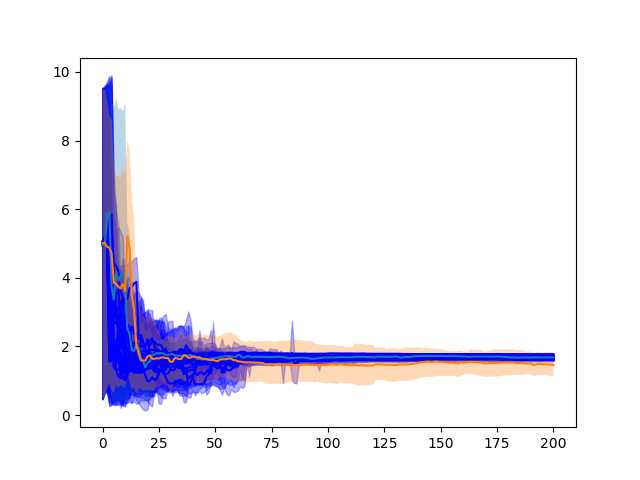

In [9]:
fig = plt.figure()
idx_param = m.RabiRamseyModel.IDX_ZEEMAN
for idx_df in range(panel_bernoulli_risk.n_dataframes):
    df = panel_bernoulli_risk.panel[idx_df]
    plt.plot(np.array(list(df.smc_mean))[:,idx_param], color='b')
    plt.fill_between(
        np.arange(201),
        np.array(list(df.smc_lower_quantile))[:,idx_param],
        np.array(list(df.smc_upper_quantile))[:,idx_param],
        alpha=0.3,
        color='b'
    )
    
for idx_df in range(panel_linear.n_dataframes):
    df = panel_linear.panel[idx_df]
    plt.plot(np.array(list(df.smc_mean))[:,idx_param])
    plt.fill_between(
        np.arange(201),
        np.array(list(df.smc_lower_quantile))[:,idx_param],
        np.array(list(df.smc_upper_quantile))[:,idx_param],
        alpha=0.3
    )

In [24]:
def bat(x, *args, **kwargs):
    pass

In [17]:
df=full_risk.panel[50]

<IPython.core.display.Javascript object>


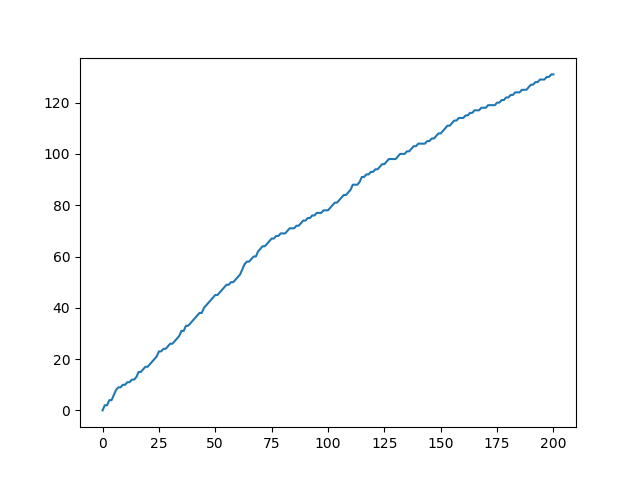

In [22]:
plt.figure()
plt.plot(df.smc_resample_count)

In [16]:
np.prod(np.diag(list(full_risk.panel[50].smc_cov)[-1])[:5])

1.3309621125271516e-16

<IPython.core.display.Javascript object>


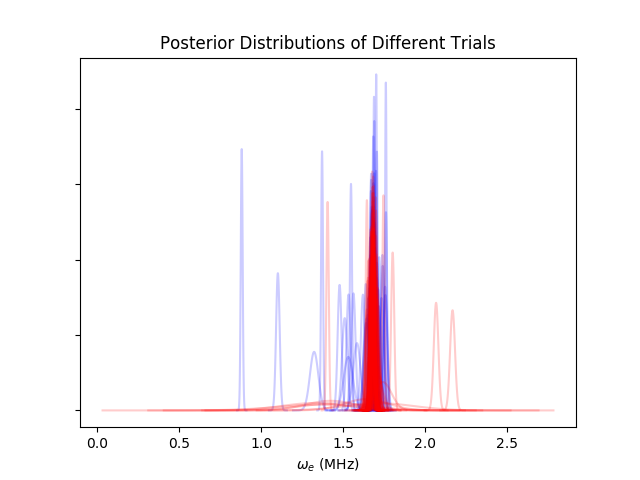

[]

In [6]:
fig = plt.figure()
panel = full_risk
idx_param = 1
for idx_trial in range(panel.n_dataframes):
    mean = np.array(list(panel.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(panel.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std), alpha=0.2, color='b')
    
panel = classic_linear
idx_param = 1
for idx_trial in range(panel.n_dataframes):
    mean = np.array(list(panel.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(panel.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std), alpha=0.2, color='r')
    
plt.title('Posterior Distributions of Different Trials')
plt.xlabel('${}$ (MHz)'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.gca().set_yticklabels([])

In [ ]:
import structured

<IPython.core.display.Javascript object>


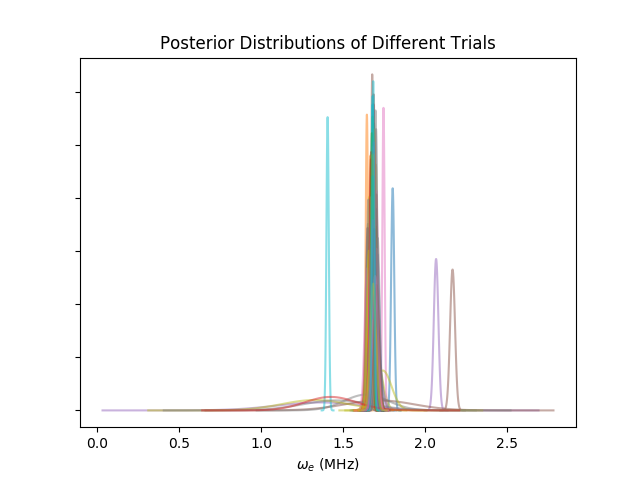

[]

In [7]:
fig = plt.figure()
panel = classic_linear
idx_param = 1
for idx_trial in range(panel.n_dataframes):
    mean = np.array(list(panel.panel[idx_trial].smc_mean))[-1,idx_param]
    std = np.sqrt(np.array(list(panel.panel[idx_trial].smc_cov))[-1,idx_param,idx_param])
    x_vals = np.linspace(mean-5*std, mean+5*std, 100)
    plt.plot(x_vals, st.norm.pdf(x_vals, mean, std), alpha=0.5)
    
plt.title('Posterior Distributions of Different Trials')
plt.xlabel('${}$ (MHz)'.format(m.RabiRamseyModel().modelparam_names[idx_param]))
plt.gca().set_yticklabels([])